In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from collections import Counter
from plotly import express as ex

%matplotlib inline

In [2]:
PATH = "."

In [3]:
train = pd.read_csv(f"{PATH}/data.csv")

In [4]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,509,147,621,254
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,444,146,514,258
2,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,345,219,457,328
3,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,287,340,407,445
4,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,1,154,86,245


In [5]:
train['xmin'],train['xmax'] = train['xmin'] / 640,train['xmax'] / 640
train['ymin'],train['ymax'] = train['ymin'] / 480,train['ymax'] / 480

In [6]:
train['h'] = train.ymax - train.ymin
train['w'] = train.xmax - train.xmin

train['y'] = train.ymin + (train.h / 2)
train['x'] = train.xmin + (train.w / 2)

In [7]:
train.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,h,w,y,x
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.795312,0.306250,0.970313,0.529167,0.222917,0.175000,0.417708,0.882812
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.693750,0.304167,0.803125,0.537500,0.233333,0.109375,0.420833,0.748437


In [8]:
class JSON(object):
    """
    Helper Class For Mapping JSON vars to Objects
    """
    def __init__(self,data=dict(),inner=False):
        for key in data:
            if type(data[key]) == dict:
                self.__dict__[key] = JSON(data[key],inner=True)
            else:
                self.__dict__[key] = data[key]

    def __repr__(self):
        return self.__dict__.__str__()
    
    def __str__(self):
        return self.__dict__.__str__()
    
    def __getitem__(self,key):
        return self.__dict__[key]
    
    def __setitem__(self,key,value):
        self.__dict__[key] = value
    
    def __iter__(self):
        for key in self.__dict__:
            if type(self.__dict__[key]) == JSON:
                yield key, self.__dict__[key]()
            else:
                yield key, self.__dict__[key]
        
    def __call__(self,):
        return {i:j for i,j in  self.__iter__()}

In [9]:
data = []
grouped = train.groupby(by='filename')

for i in train.filename.unique():
    group = grouped.get_group(i)[['class','xmin','ymin','xmax','ymax','x','y','h','w']]
    group = group[group['class'] == 'RBC']
    group = group.T.to_dict().values()
    boxes = [JSON(i) for i in group]
    if len(boxes):
        data.append(JSON({
            'filename':i,
            'boxes':boxes
        }))

In [10]:
len(data)

349

In [11]:
64 * 6

384

In [12]:
IMG_SIZE = 384

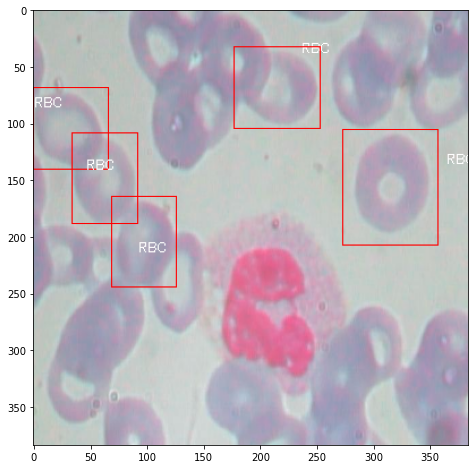

In [13]:
image = data[np.random.randint(len(data))]

img = cv2.imread(image['filename'])
img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))

for box in image['boxes']:
    img = cv2.putText(img,box['class'],(int(box['xmin']*512),int(box['ymin']*512)-5),cv2.FONT_HERSHEY_SIMPLEX,0.4,(255,255,255))
    img = cv2.rectangle(
            img,
            (int(box.xmin*IMG_SIZE),int(box.ymin*IMG_SIZE)),
            (int(box.xmax*IMG_SIZE),int(box.ymax*IMG_SIZE)),
            (255,0,0),
            1
        )

plt.figure(figsize=(12,8))
plt.imshow(img)

In [14]:
images = np.array([cv2.resize(cv2.imread(i['filename']),(IMG_SIZE,IMG_SIZE)) for i in data])

In [15]:
images = images.astype(np.float32) / 255

In [212]:
hw = ((train[['h','w']].copy()*IMG_SIZE).astype(np.uint16) / 64)*64

In [213]:
ex.scatter(data_frame=hw,x='w',y='h')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


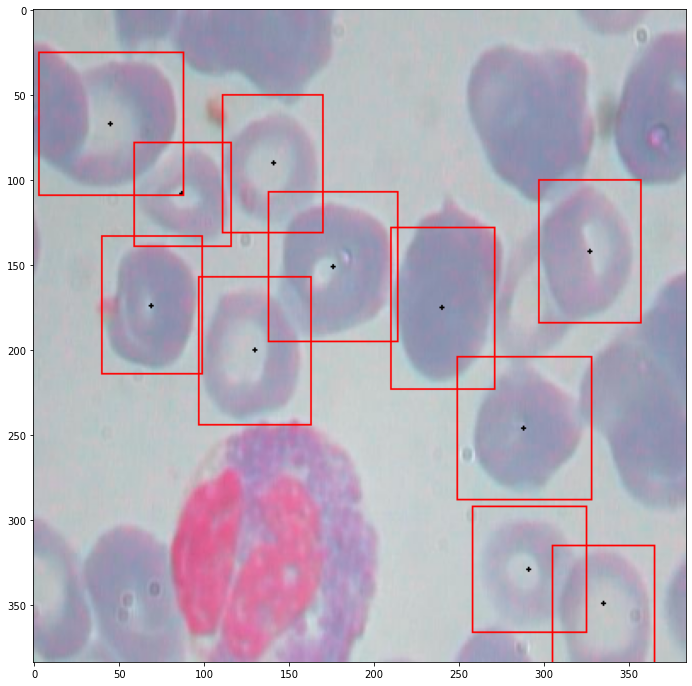

In [18]:
i = np.random.randint(len(images))

img = images[i].copy()
dat = data[i]

for d in dat.boxes:
    img = cv2.rectangle(
                    img,
                    (int(d.xmin*IMG_SIZE),int(d.ymin*IMG_SIZE)),
                    (int(d.xmax*IMG_SIZE),int(d.ymax*IMG_SIZE)),
                    (255,0,0),
                    1
                )
    
    img = cv2.circle(
                    img,
                    (int(d.x*IMG_SIZE),int(d.y*IMG_SIZE)),
                    1,
                    (0,0,0),
                    -1
                )

plt.figure(figsize=(12,12
                   ))
plt.imshow(img)

In [228]:
k = 5

In [261]:
class AnchorGrid(object):
    
    def __init__(self,resize_factor,k,image_size,box_gen):
        
        self.k = k
        self.resize_factor = resize_factor
        self.image_size = image_size
        self.grid_size = image_size // resize_factor
        self.box_gen = box_gen
        
        self.repr = f"""
AnchorGrid (
    resize_factor={self.resize_factor},
    k={self.k},
    image_size={self.image_size},
    grid_size={self.grid_size}
)"""
        
    def __repr__(self,):
        return self.repr
                
    def __call__(self,data):
        """
        Returns : encoded_prob,encoded_box
        """
        box = np.zeros((self.grid_size,self.grid_size,self.k,4))
        prob = np.zeros((self.grid_size,self.grid_size,self.k,1))

        boxt = np.round(np.array([[b.y,b.x,b.h,b.w] for b in data.boxes])*IMG_SIZE).astype(np.float32)
        boxt = pd.DataFrame(boxt,columns=['y','x','h','w']).sort_values(by=['y','x','h','w']).values

        _counter = Counter()

        for y,x,h,w in boxt:
            Ox = int(x // self.resize_factor) 
            Oy = int(y // self.resize_factor) 

            if Ox == self.grid_size or Oy == self.grid_size:
                continue

            x = (x - (Ox*self.resize_factor)) / self.resize_factor
            y = (y - (Oy*self.resize_factor)) / self.resize_factor
            
            h,w = self.box_gen.encode(h,w)
                        
            Oi = _counter[f"{Oy}x{Ox}"]
            
            box[Oy,Ox,Oi,:] = [y,x,h,w]
            prob[Oy,Ox,Oi,:] = [1]
            
            _counter[f"{Oy}x{Ox}"] += 1

        return prob.reshape(-1,self.k,1),box.reshape(-1,self.k,4)
    
    def generate(self,ret=False):
        xx,yy = np.meshgrid(np.arange(self.grid_size),np.arange(self.grid_size))
        xx,yy = np.reshape(xx,(self.grid_size,self.grid_size,1)),np.reshape(yy,(self.grid_size,self.grid_size,1))
        
        self.reference = np.concatenate((yy,xx),axis=-1)
        self.grid = self.reference.copy() * self.resize_factor
        self.grid += self.resize_factor // 2
        
        if ret:
            return self.grid.copy(),self.reference.copy()

    def get_pair(self,x,y,resize=False):
        return ((x-(self.resize_factor//2),y-(self.resize_factor//2)),
                (x+(self.resize_factor//2),y+(self.resize_factor//2)))
        
class BoxGrid(object):
    """
    Encodes Box
    """
    def __init__(self,low,high):
        self.low = low
        self.high = high
        self.repr = f"""
BoxGrid(
    low={self.low},
    high={self.high}
)
        """
    
    def __repr__(self):
        return self.repr
    
    def encode(self,h,w):
        h = np.min((np.max((self.low,h)),self.high))
        w = np.min((np.max((self.low,w)),self.high))
        return h/self.high,w/self.high
    
    def get_pair(self,y,x,h,w):
        h = int(h*self.high)
        w = int(w*self.high)
        return (x - (h//2),y - (h//2)),(x + (h//2),y + (h//2))
    
    def decode(self,):
        pass
    
    def encodeBatch(self,):
        pass
    
    def decodeBatch(self,):
        pass

In [262]:
box_grid_6 = BoxGrid(64,128)

In [263]:
anc_6x6 = AnchorGrid(64,k,IMG_SIZE,box_grid_6)
anc_6x6.generate()

In [264]:
i = np.random.randint(len(images))
img = images[i].copy()
dat = data[i]

grid,ref = anc_6x6.generate(ret=True)
pa,ba = anc_6x6(dat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


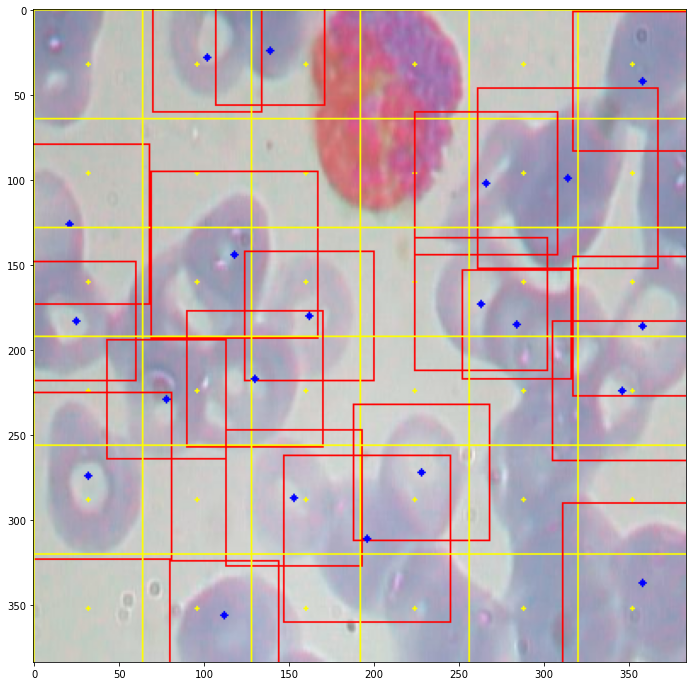

In [267]:
for cord,prob,(y,x) in zip(ba,pa,grid.reshape(-1,2)):
    img = cv2.circle(
                    img,
                    (int(x),int(y)),
                    1,
                    (255,255,0),
                    -1
                )
    
    (xmin,ymin),(xmax,ymax) = anc_6x6.get_pair(x,y)
    
    img = cv2.rectangle(
                    img,
                    (xmin,ymin),
                    (xmax,ymax), 
                    (255,255,0),
                    (1)
                )
    
    for (yy,xx,hh,ww),(p,) in zip(cord.reshape(-1,4),prob.reshape(-1,1)):
        if p:
            xx = x+int(xx*anc_6x6.resize_factor)-(anc_6x6.resize_factor//2)
            yy = y+int((yy*anc_6x6.resize_factor))-(anc_6x6.resize_factor//2)
            img = cv2.circle(
                        img,
                        (xx,yy),
                        2,
                        (0,0,255),
                        -1
                    )
            (xmin,ymin),(xmax,ymax) = anc_6x6.box_gen.get_pair(yy,xx,hh,ww)
            img = cv2.rectangle(
                img,
                (xmin,ymin),
                (xmax,ymax),
                (255,0,0),
                1
            )
            
    

# for j,b in enumerate(dat.boxes):
#     img = cv2.rectangle(
#                     img,
#                     (int(b.xmin*IMG_SIZE),int(b.ymin*IMG_SIZE)),
#                     (int(b.xmax*IMG_SIZE),int(b.ymax*IMG_SIZE)),
#                     (255,0,0),
#                     1
#                 )
    
    
plt.figure(figsize=(12,12))
plt.imshow(img)

In [273]:
y_prob = []
y_box = []

for d in data:
    p,b = anc_6x6(d)
    
    y_box.append(b)
    y_prob.append(p)
    
y_prob = np.array(y_prob)
y_box = np.array(y_box)

In [274]:
y_prob.shape,y_box.shape

((349, 36, 5, 1), (349, 36, 5, 4))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


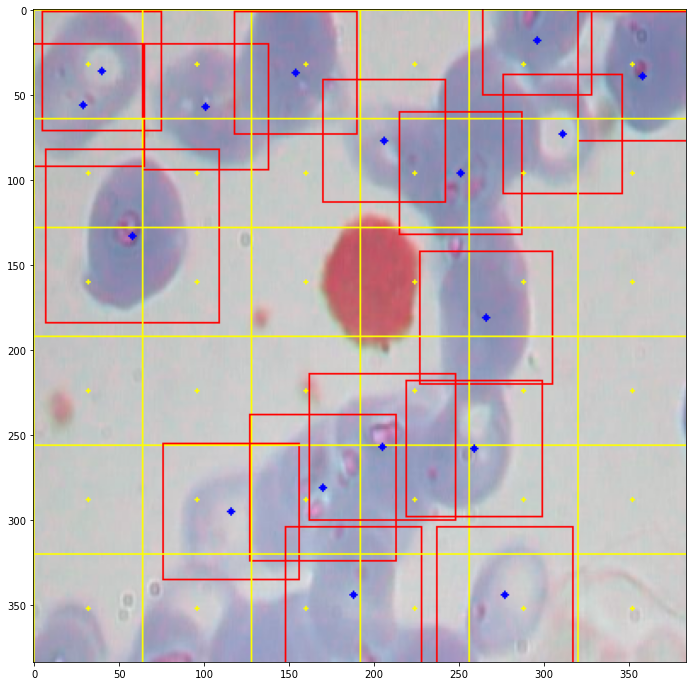

In [281]:
i = np.random.randint(0,len(images))
img = images[i].copy()
dat = data[i]
ba = y_box[i].copy()
pa = y_prob[i].copy()

for cord,prob,(y,x) in zip(ba,pa,anc_6x6.grid.copy().reshape(-1,2)):
    img = cv2.circle(
                    img,
                    (int(x),int(y)),
                    1,
                    (255,255,0),
                    -1
                )
    
    (xmin,ymin),(xmax,ymax) = anc_6x6.get_pair(x,y)
    
    img = cv2.rectangle(
                    img,
                    (xmin,ymin),
                    (xmax,ymax),
                    (255,255,0),
                    (1)
                )
    
    for (yy,xx,hh,ww),(p,) in zip(cord.reshape(-1,4),prob.reshape(-1,1)):
        if p:
            xx = x+int(xx*anc_6x6.resize_factor)-(anc_6x6.resize_factor//2)
            yy = y+int((yy*anc_6x6.resize_factor))-(anc_6x6.resize_factor//2)
            img = cv2.circle(
                        img,
                        (xx,yy),
                        2,
                        (0,0,255),
                        -1
                    )
            (xmin,ymin),(xmax,ymax) = anc_6x6.box_gen.get_pair(yy,xx,hh,ww)
            img = cv2.rectangle(
                img,
                (xmin,ymin),
                (xmax,ymax),
                (255,0,0),
                1
            )
        
    

# for j,b in enumerate(dat.boxes):
#     img = cv2.rectangle(
#                     img,
#                     (int(b.xmin*IMG_SIZE),int(b.ymin*IMG_SIZE)),
#                     (int(b.xmax*IMG_SIZE),int(b.ymax*IMG_SIZE)),
#                     (255,0,0),
#                     1
#                 )
    
    
plt.figure(figsize=(12,12))
plt.imshow(img)

In [282]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,Callback

In [287]:
_input = Input(shape=(IMG_SIZE,IMG_SIZE,3))


def block(name:str,filters:int,ksize:int,_input:Layer,pool=False):
    block_0 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"block_{name}_conv0")(_input)
    block_1 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"block_{name}_conv1")(block_0)
    block_2 = BatchNormalization(name=f"block_{name}_norm_0")(block_1)
    block_3 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"block_{name}_conv2")(block_2)
    block_4 = Conv2D(filters,1,activation="relu",padding="same",name=f"block_{name}_conv3")(block_3)
    block_5 = BatchNormalization(name=f"block_{name}_norm_1")(block_4)
    
    block_out = concatenate([_input,block_5],name=f"block_{name}_conc")
    if pool:
        block_out = MaxPool2D(name=f"block_{name}_pool")(block_out)
    return block_out


def out(_in,k,name):
    prob = Conv2D(k,1,padding="same",name=f"prob_conv_{name}")(_in)
    prob = BatchNormalization(name=f"prob_norm_{name}")(prob)
    prob = Activation("sigmoid",name=f"prob_out_{name}")(prob)
    prob = Reshape((-1,k,1),name="prob")(prob)

    box = Conv2D(k*4,1,padding="same",name=f"box_conv_{name}")(_in)
    box = BatchNormalization(name=f"box_batch_{name}")(box)
    box = Activation("sigmoid",name=f"box_out_{name}")(box)
    box = Reshape((-1,k,4),name="box")(box)
    
    return prob,box

### input block
_in = Conv2D(32,7,activation="relu",padding="same",)(_input)
_in = AvgPool2D()(_in)
#### Output Shape = 192x192x32

### Fine Grained Features
a  = block(name="a",filters=32,ksize=3,_input=_in,pool=True) ### Output Shape = 96x96x64
b  = block(name="b",filters=64,ksize=3,_input=a,pool=True) ### Output Shape = 48x48x128
c  = block(name="c",filters=128,ksize=3,_input=b,pool=True) ### Output Shape = 24x24x256

fpn0  = block(name="fpn0",filters=256,ksize=3,_input=c,pool=True) ### 12x12x512
# (prob_0,box_0) = out(fpn0,2,"fpn0")

fpn1  = block(name="fpn1",filters=512,ksize=3,_input=fpn0,pool=True) ### 6x6x1024
(prob_1,box_1) = out(fpn1,5,"fpn1")

# fpn2  = block(name="fpn2",filters=1024,ksize=3,_input=fpn1,pool=True) ### 3x3x2048
# (prob_2,box_2) = out(fpn2,4,"fpn2")

net = keras.Model(_input,[prob_1,box_1])
prob_train = keras.Model(_input,prob_1)

In [288]:
# keras.utils.plot_model(net,show_shapes=True,show_layer_names=True,expand_nested=True,dpi=128)

In [289]:
net.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 384, 384, 32) 4736        input_9[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_8 (AveragePoo (None, 192, 192, 32) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
block_a_conv0 (Conv2D)          (None, 192, 192, 32) 9248        average_pooling2d_8[0][0]        
___________________________________________________________________________________________

In [446]:
%%time

i = np.random.randint(0,len(images))
a = net(images[i:i+1])

Wall time: 80.8 ms


In [638]:
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()

In [448]:
g = 6

class BoxLoss(tf.Module):
    """
    Loss For Bounding Box
    """
    def __init__(self,grid_size,k):
        pass
    
    def __call__(y_true,y_pred,*args,**kwargs):
        b_pred = tf.reshape(y_pred,(-1,k*g*g,2))
        b_true = tf.reshape(y_true,(-1,k*g*g,2))

        mask = tf.greater(b_true , zeroes)
        mask = tf.reshape(tf.logical_or(tf.slice(mask,[0,0,0],[-1,-1,1]),tf.slice(mask,[0,0,1],[-1,-1,1])),(-1,k*g*g))
        
        return l2_loss(b_true[mask],b_pred[mask])

In [634]:
i = 0
_,y_pred  = net(images[i:i+1])
y_true  = y_box[i:i+1].copy().astype(np.float32)

In [667]:
class BoxLoss(tf.Module):
    """
    BoxLoss
    """
    def __init__(self,grid_size,k):
        self.grid_size = grid_size
        self.k = k
        self.zero = tf.constant(0,tf.float32)
        self.one = tf.constant(1,tf.float32)
        self.l2_loss = tf.keras.losses.MeanSquaredError()

        self.slice_y = {"begin":[0,0,0],"size":[-1,-1,1]}
        self.slice_x = {"begin":[0,0,1],"size":[-1,-1,1]}
        self.slice_h = {"begin":[0,0,2],"size":[-1,-1,1]}
        self.slice_w = {"begin":[0,0,3],"size":[-1,-1,1]}
        
        self.repr = f"""
BoxLoss(
    grid_size={grid_size},
    k={k}
)
        """
        
    def __repr__(self,):
        return self.repr

    
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        b_pred = tf.reshape(y_pred,(-1,k*grid_size*grid_size,4))
        b_true = tf.reshape(y_true,(-1,k*grid_size*grid_size,4))
        
        y = tf.slice(b_true,**self.slice_y)
        x = tf.slice(b_true,**self.slice_x)

        mask = tf.logical_or(tf.greater(y,zero),tf.greater(x,zero))

        y = y[mask] 
        x = x[mask] 
        h = tf.slice(b_true,**self.slice_h)[mask] 
        w = tf.slice(b_true,**self.slice_w)[mask] 

        y_ = tf.slice(b_pred,**self.slice_y)[mask] 
        x_ = tf.slice(b_pred,**self.slice_x)[mask] 
        h_ = tf.slice(b_pred,**self.slice_h)[mask] 
        w_ = tf.slice(b_pred,**self.slice_w)[mask] 
        
        w2  = tf.divide(w,2)
        h2  = tf.divide(h,2)
        w2_  = tf.divide(w_,2)
        h2_  = tf.divide(h_,2)
        
        xmin = tf.subtract(x,w2)
        xmax = tf.add(x,w2)
        ymin = tf.subtract(y,h2)
        ymax = tf.add(y,h2)
        
        xmin_ = tf.subtract(x_,w2_)
        xmax_ = tf.add(x_,w2_)
        ymin_ = tf.subtract(y_,h2_)
        ymax_ = tf.add(y_,h2_)
        
        Cymin = tf.maximum(ymin,ymin_)
        Cymax = tf.minimum(ymax,ymax_)
        Cxmin = tf.maximum(xmin,xmin_)
        Cxmax = tf.minimum(xmax,xmax_)

        Ch = tf.subtract(Cymax , Cymin)
        Cw = tf.subtract(Cxmax , Cxmin)
        
        Aa = tf.multiply( h , w )
        Ba = tf.multiply( h_ , w_ )
        Ca = tf.multiply( Cw , Ch )
        
        IoU = tf.reduce_mean(tf.subtract(self.one,tf.divide(Ca,tf.subtract(tf.add(Aa,Ba),Ca))))
        Xl2 = self.l2_loss(x,x_)
        Yl2 = self.l2_loss(y,y_)
        
        return Xl2 + Yl2 + IoU

In [668]:
boxloss = BoxLoss(6,k)
boxloss


BoxLoss(
    grid_size=6,
    k=5
)
        

In [669]:
def schedule(epoch):
    if epoch > 35:
        return .000001
    elif epoch > 20:
        return .00001
    elif epoch > 10:
        return .0001
    else:
        return .001

In [670]:
lrs = LearningRateScheduler(schedule=schedule,)
chk = ModelCheckpoint(filepath="./checkpoints/net1.1",save_weights_only=True,monitor='loss',)

In [671]:
opt = keras.optimizers.Adam()

In [672]:
net.compile(optimizer=opt,loss={"prob":binary_crossentropy,"box":boxloss})

In [673]:
net.fit(images,(y_prob,y_box),batch_size=1,epochs=45,callbacks=[chk])

Train on 349 samples
Epoch 1/45
349/349 [==============================] - 42s 120ms/sample - loss: 1.2681 - prob_loss: 0.5840 - box_loss: 0.6841
Epoch 2/45
349/349 [==============================] - 39s 111ms/sample - loss: 0.9939 - prob_loss: 0.4462 - box_loss: 0.5477
Epoch 3/45
349/349 [==============================] - 39s 112ms/sample - loss: 0.8595 - prob_loss: 0.3549 - box_loss: 0.5046
Epoch 4/45
349/349 [==============================] - 39s 110ms/sample - loss: 0.7738 - prob_loss: 0.2932 - box_loss: 0.4805
Epoch 5/45
349/349 [==============================] - 39s 111ms/sample - loss: 0.7008 - prob_loss: 0.2479 - box_loss: 0.4529
Epoch 6/45
349/349 [==============================] - 38s 110ms/sample - loss: 0.6480 - prob_loss: 0.2147 - box_loss: 0.4333
Epoch 7/45
349/349 [==============================] - 38s 110ms/sample - loss: 0.6035 - prob_loss: 0.1868 - box_loss: 0.4168
Epoch 8/45
349/349 [==============================] - 39s 111ms/sample - loss: 0.5652 - prob_loss: 0.165

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


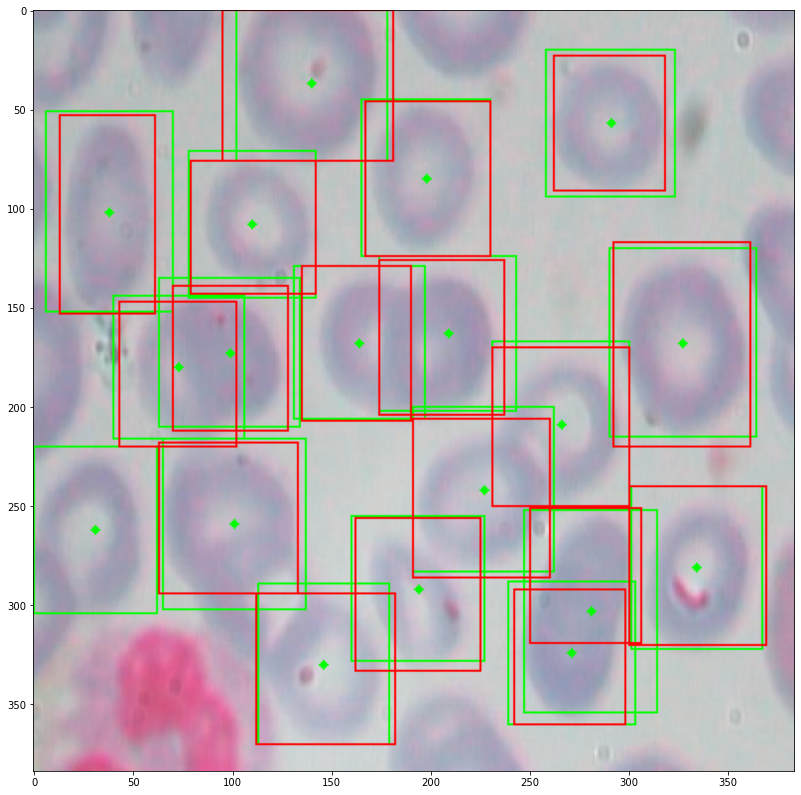

In [687]:
i = np.random.randint(len(images))

img = images[i].copy()
pa,ba = net.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
dat = data[i]

for (y,x),ps,bs in zip(grid.reshape(-1,2),pa.reshape(-1,k,1),ba.reshape(-1,k,4)):
    
#     img = cv2.rectangle(
#         img,
#         (x-(anc_6x6.resize_factor//2),y-(anc_6x6.resize_factor//2)),
#         (x+(anc_6x6.resize_factor//2),y+(anc_6x6.resize_factor//2)),
#         (255,255,0),
#         1
#     )
    
    for (p,),(yy,xx,hh,ww) in zip(ps,bs):
        if p > .5:
            yy,xx = int(yy*64),int(xx*64)
            xx,yy = x-32+xx,y-32+yy
            img = cv2.circle(img,(xx,yy),2,(0,255,0),-1)
            
            hh = int(hh*128)
            ww = int(ww*128)
            
            xmin = int(xx - (ww/2))
            ymin = int(yy - (hh/2))
            
            xmax = int(xx + (ww/2))
            ymax = int(yy + (hh/2))
            
            img = cv2.rectangle(
                img,
                (xmin,ymin),
                (xmax,ymax),
                (0,255,0),
                1
            )
    
for j,b in enumerate(dat.boxes):
    img = cv2.rectangle(
                    img,
                    (int(b.xmin*IMG_SIZE),int(b.ymin*IMG_SIZE)),
                    (int(b.xmax*IMG_SIZE),int(b.ymax*IMG_SIZE)),
                    (255,0,0),
                    1
                )
    
plt.figure(figsize=(14,14))
plt.imshow(img)